In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


# Modeling
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [4]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical + CS7",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Decision Tree",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": None,
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [5]:
df = pd.read_csv("../../../../../../data/processed/partner_ii/cement-shipping.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [6]:
df_copy = df.drop(
    [
        # Properties
        
        "Initial setting time",
        "Blaine",
        "Sieve 32 um",
        "Sieve 45 um",
        "CS1",
        "CS3",
        "Cement_Type",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [7]:
PARAMS = {
    "criterion": "squared_error",
    "max_depth": 3,
    "random_state": SEED,
    "splitter": "best",
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [8]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 123 samples each
    2. 90% train (1111 samples each fold)
    3. 10% test (123 samples each fold)
<b>Total:</b> 100 models<br>

In [9]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.749 (0.252)
MAE: -1.379 (0.198)
MAPE: -0.033 (0.005)
R2: 0.748 (0.083)


******
[TEST]
******
RMSE: -1.839 (0.193)
MAE: -1.455 (0.144)
MAPE: -0.034 (0.003)
R2: 0.725 (0.047)




<IPython.core.display.Javascript object>

In [10]:
pd.concat(results_to_save).reset_index().groupby(
    ["Features", "Model", "Cross Validation"], dropna=False
)[["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features          Model Cross Validation RMSE Test  \
                                                                       mean   
0  Chemical + Mineralogical + CS7  Decision Tree   Repeated KFold  1.838506   

             MAE Test           MAPE Test             R2 Test            
        std      mean       std      mean       std      mean       std  
0  0.193285  1.455458  0.144313  0.034377  0.003399  0.724633  0.046779

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [11]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.695 (0.220)
MAE: -1.351 (0.178)
MAPE: -0.032 (0.005)
R2: 0.690 (0.104)


******
[TEST]
******
RMSE: -2.075 (0.239)
MAE: -1.669 (0.224)
MAPE: -0.039 (0.007)
R2: 0.512 (0.200)




<IPython.core.display.Javascript object>

In [12]:
pd.concat(results_to_save).reset_index().groupby(
    ["Features", "Model", "Cross Validation"], dropna=False
)[["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features          Model            Cross Validation  \
                                                                               
0  Chemical + Mineralogical + CS7  Decision Tree  Blocking Time Series Split   
1  Chemical + Mineralogical + CS7  Decision Tree              Repeated KFold   

  RMSE Test            MAE Test           MAPE Test             R2 Test  \
       mean       std      mean       std      mean       std      mean   
0  2.074737  0.239250  1.669118  0.224167  0.038833  0.006775  0.512234   
1  1.838506  0.193285  1.455458  0.144313  0.034377  0.003399  0.724633   

             
        std  
0  0.199954  
1  0.046779

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 114, 226, 338, 450, 562, 675, 787, 899, 1011, 1123 samples each fold
    2. Test: 112 samples each fold
<b>Total:</b> 10 models<br>

In [13]:
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.823 (0.146)
MAE: -1.460 (0.126)
MAPE: -0.034 (0.003)
R2: 0.703 (0.050)


******
[TEST]
******
RMSE: -2.307 (0.351)
MAE: -1.882 (0.329)
MAPE: -0.045 (0.011)
R2: 0.392 (0.263)




<IPython.core.display.Javascript object>

In [14]:
pd.concat(results_to_save).groupby(["Features", "Model", "Cross Validation"])[
    ["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]
].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features          Model            Cross Validation  \
                                                                               
0  Chemical + Mineralogical + CS7  Decision Tree  Blocking Time Series Split   
1  Chemical + Mineralogical + CS7  Decision Tree              Repeated KFold   
2  Chemical + Mineralogical + CS7  Decision Tree           Time Series Split   

  RMSE Test            MAE Test           MAPE Test             R2 Test  \
       mean       std      mean       std      mean       std      mean   
0  2.074737  0.239250  1.669118  0.224167  0.038833  0.006775  0.512234   
1  1.838506  0.193285  1.455458  0.144313  0.034377  0.003399  0.724633   
2  2.306742  0.350857  1.881517  0.329304  0.044728  0.010692  0.391754   

             
        std  
0  0.199954  
1  0.046779  
2  0.262567

<IPython.core.display.Javascript object>

## 1.4. Out of time Split Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Train size: 80%</b><br>
<b>Test  size: 20%</b>


<b>Splits:</b> 2<br>    
    1. Train: 987
    2. Test: 247
<b>Total:</b> 1 model<br>

In [15]:
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=SEED, shuffle=False
)
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)

pipeline.fit(x_train, y_train)

y_train_pred = pipeline.predict(x_train)
y_test_pred = pipeline.predict(x_test)

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Out of time Split"
results_dict_copy["Cross Validation Params"] = '{"Test Size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(
    results_dict_copy, {key: [value] for key, value in scores.items()}
)
results_to_save.append(df_results)

******
[TRAIN]
******
RMSE: 1.555 (0.000)
MAE: 1.235 (0.000)
MAPE: 0.028 (0.000)
R2: 0.772 (0.000)


******
[TEST]
******
RMSE: 2.835 (0.000)
MAE: 2.331 (0.000)
MAPE: 0.061 (0.000)
R2: -0.038 (0.000)




<IPython.core.display.Javascript object>

In [16]:
pd.concat(results_to_save).groupby(["Features", "Model", "Cross Validation"])[
    ["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]
].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features          Model            Cross Validation  \
                                                                               
0  Chemical + Mineralogical + CS7  Decision Tree  Blocking Time Series Split   
1  Chemical + Mineralogical + CS7  Decision Tree           Out of time Split   
2  Chemical + Mineralogical + CS7  Decision Tree              Repeated KFold   
3  Chemical + Mineralogical + CS7  Decision Tree           Time Series Split   

  RMSE Test            MAE Test           MAPE Test             R2 Test  \
       mean       std      mean       std      mean       std      mean   
0  2.074737  0.239250  1.669118  0.224167  0.038833  0.006775  0.512234   
1  2.835439  0.000000  2.331154  0.000000  0.060793  0.000000 -0.037772   
2  1.838506  0.193285  1.455458  0.144313  0.034377  0.003399  0.724633   
3  2.306742  0.350857  1.881517  0.329304  0.044728  0.010692  0.391754   

             
        std  
0  0.199954  
1  0.000000  
2  0.046779  
3  0.262567

<IPython.core.display.Javascript object>

# Saving the results Dataframe

## Saving the full dataframe

In [17]:
path = "../../../../../../reports/results/local_models/partner_ii/all_cements/full/"
filename = "decision_tree_results_full_13.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

## Saving the grouped dataframe

In [18]:
cols_groupby = [
    "Category",
    "Company",
    "Data Shape",
    "Timesteps",
    "Features",
    "Model",
    "Cross Validation",
    "Cross Validation Params",
]

cols_agg = ["RMSE Train", "MAE Train", "MAPE Train", "R2 Train"] + [
    "RMSE Test",
    "MAE Test",
    "MAPE Test",
    "R2 Test",
]

path = "../../../../../../reports/results/local_models/partner_ii/all_cements/grouped/"
filename = "decision_tree_results_grouped_13.csv"


df_results_to_save = (
    pd.concat(results_to_save)
    .groupby(cols_groupby, dropna=False)[cols_agg]
    .agg(["mean", lambda series: pd.Series(series.std(ddof=0), name="std")])
    .reset_index()
    .rename(columns={"<lambda_0>": "std"})
)

df_results_to_save.to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

In [19]:
from sklearn.tree import plot_tree

<IPython.core.display.Javascript object>

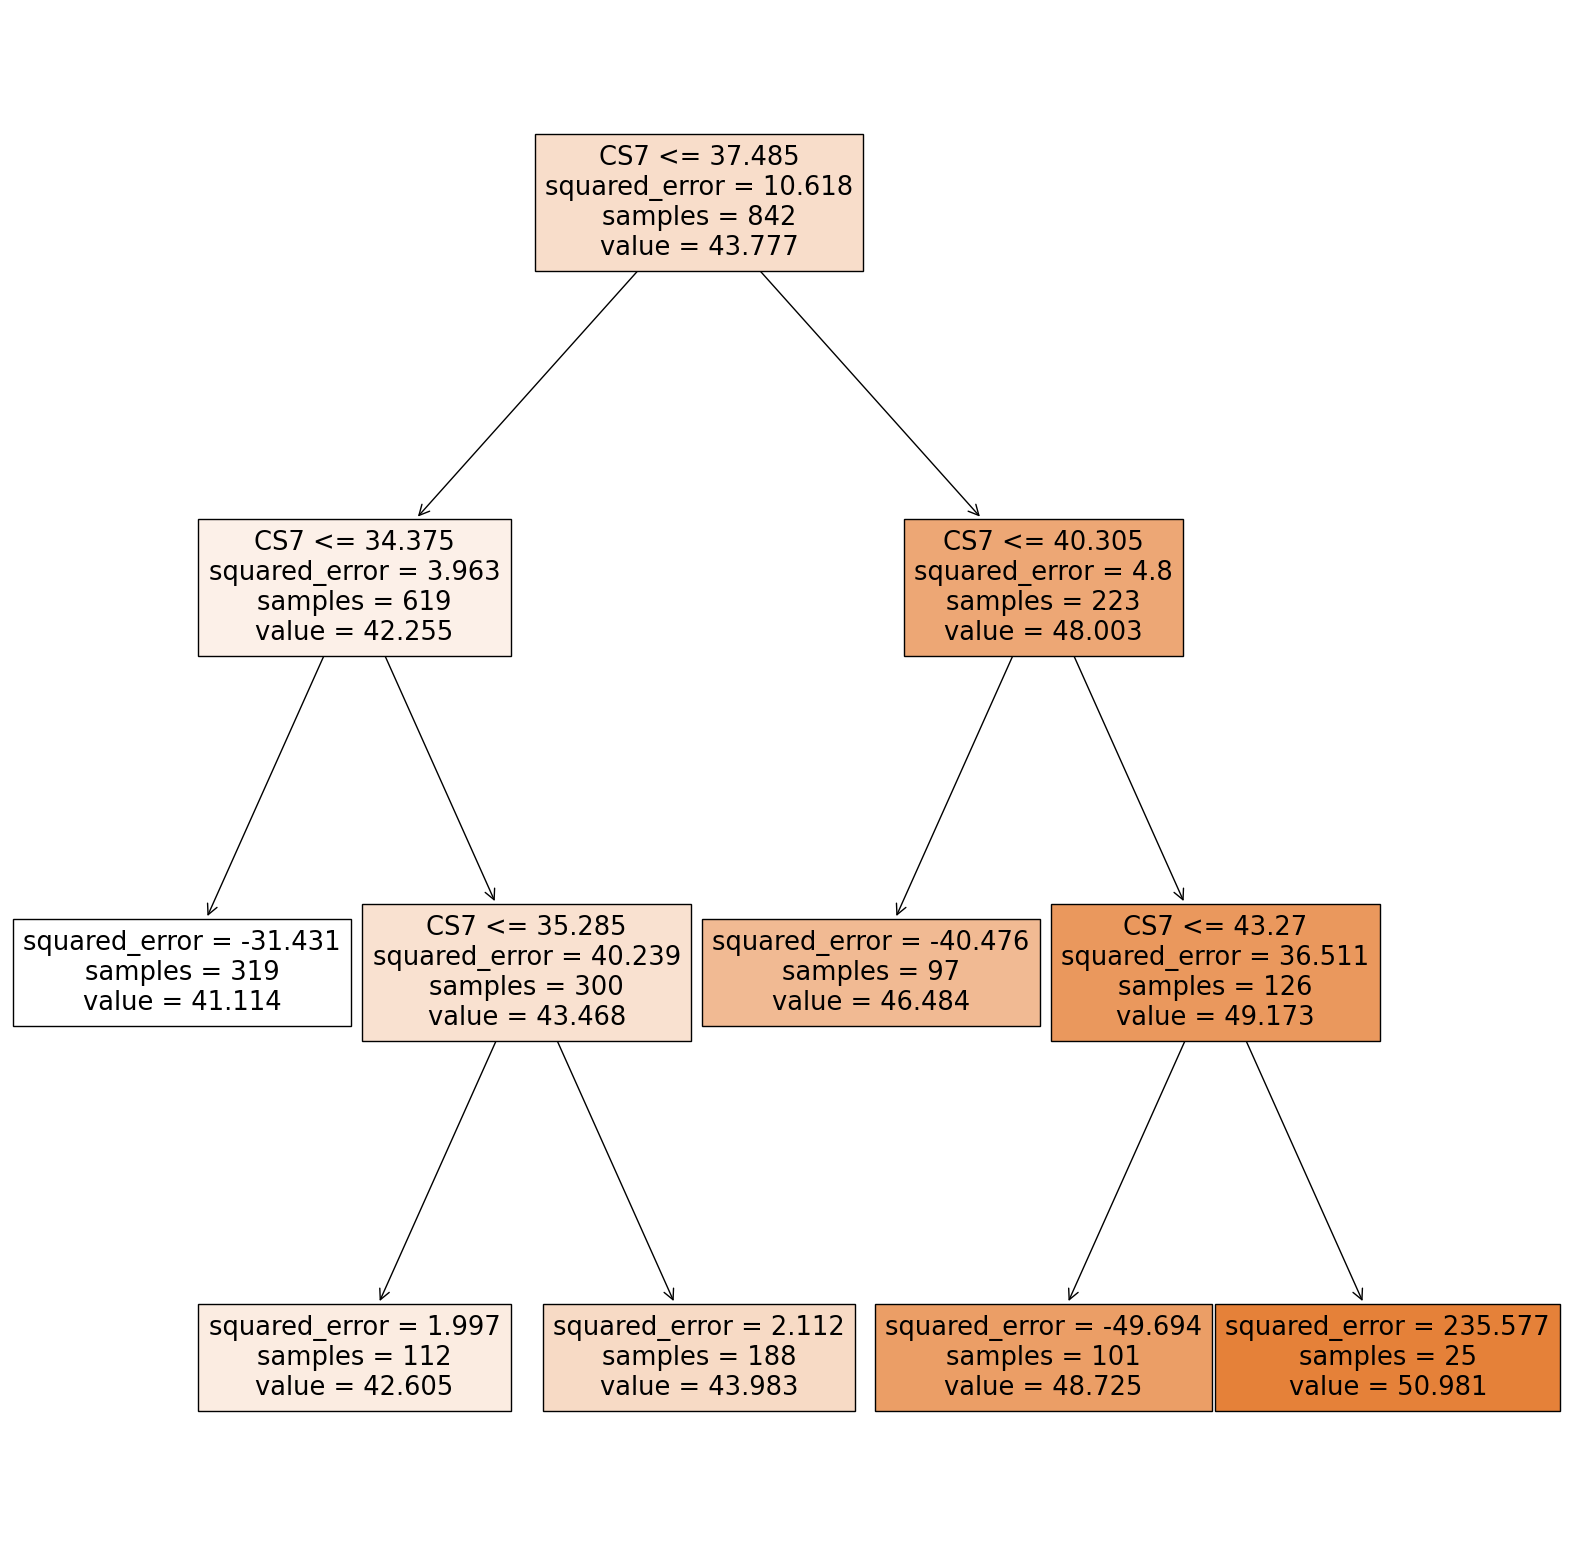

<IPython.core.display.Javascript object>

In [20]:
model = pipeline.get_params()["steps"][0][1]
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
_ = plot_tree(model, filled=True, feature_names=x.columns.to_list(), ax=ax)

<Axes: >

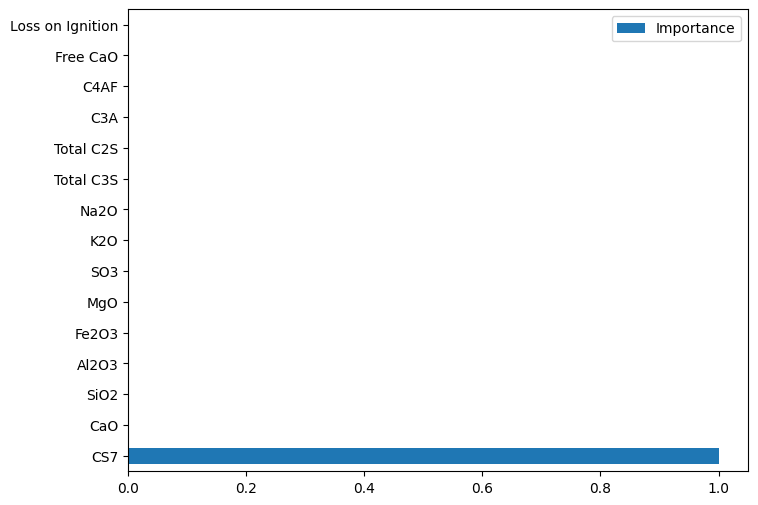

<IPython.core.display.Javascript object>

In [21]:
feat_importances = pd.DataFrame(
    model.feature_importances_, index=x.columns, columns=["Importance"]
)
feat_importances.sort_values(by="Importance", ascending=False, inplace=True)
feat_importances.plot(kind="barh", figsize=(8, 6))